In [452]:
#import libraries to predict stock prices with pytorch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F
#device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print (device)



cuda


# Data Pre Processing

In [453]:
# Load the dataset
datasetname = 'data.csv'
dataset = pd.read_csv('StockData/' + datasetname)

# Drop the 6th column (index 5)
dataset = dataset.drop(dataset.columns[5], axis=1)
# Drop the 6th column (index 5)
dataset = dataset.drop(dataset.columns[5], axis=1)

#swap column 3 with column 4 with names
cols = list(dataset.columns.values)
cols[3], cols[4] = cols[4], cols[3]
dataset = dataset[cols]

# Show the head of the normalized dataset
print(dataset.head())

df=dataset






    Open   High   Low  Volume  Close
0  12030  12030  9360    7100   9360
1   9580   9580  9230    3900   9230
2   9130   9130  9080     700   9080
3   9080   9080  9080       0   9080
4   8460   8460  8460    2700   8460


# Split the data 

In [454]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Split into training and test sets (80% train, 20% test)
train_size = int(len(scaled_data) * 0.9)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Convert the data to a format suitable for LSTM
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])
        Y.append(data[i + look_back, :])  # Predicting the entire feature set
    return np.array(X), np.array(Y)

look_back = 1  # You can change this value based on the desired look back period
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# LSTM

In [455]:
# Define the model
class NeuralNetwork(nn.Module):
    def __init__(self, num_feature):
        super(NeuralNetwork, self).__init__()
        self.lstm = nn.LSTM(num_feature, 64, batch_first=True)
        self.fc = nn.Linear(64, num_feature)
        
    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        x = self.fc(hidden[-1])
        return x

model = NeuralNetwork(num_feature=X_train.shape[2])


In [456]:
model = NeuralNetwork(num_feature=X_train.shape[2])

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train

In [457]:
# Training loop with early stopping and saving the best model
num_epochs = 50
best_val_loss = float('inf')
best_model_state = None
patience = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validate the model on the test set
    model.eval()
    with torch.no_grad():
        test_output = model(X_test)
        val_loss = criterion(test_output, y_test)
    
    # Print training and validation loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss.item():.4f}')
    
    # Check for early stopping and save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Validation loss hasn\'t improved for {patience} epochs. Early stopping...')
            break

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_model.pth')
    print('Best model saved.')
else:
    print('No improvements in validation loss. Best model not saved.')


Epoch [1/50], Train Loss: 0.1183, Val Loss: 0.1665
Epoch [2/50], Train Loss: 0.0210, Val Loss: 0.0121
Epoch [3/50], Train Loss: 0.0058, Val Loss: 0.0026
Epoch [4/50], Train Loss: 0.0016, Val Loss: 0.0006
Epoch [5/50], Train Loss: 0.0011, Val Loss: 0.0006
Epoch [6/50], Train Loss: 0.0011, Val Loss: 0.0006
Epoch [7/50], Train Loss: 0.0010, Val Loss: 0.0007
Epoch [8/50], Train Loss: 0.0010, Val Loss: 0.0007
Epoch [9/50], Train Loss: 0.0010, Val Loss: 0.0007
Epoch [10/50], Train Loss: 0.0009, Val Loss: 0.0005
Epoch [11/50], Train Loss: 0.0009, Val Loss: 0.0005
Epoch [12/50], Train Loss: 0.0009, Val Loss: 0.0006
Epoch [13/50], Train Loss: 0.0009, Val Loss: 0.0008
Epoch [14/50], Train Loss: 0.0010, Val Loss: 0.0007
Epoch [15/50], Train Loss: 0.0009, Val Loss: 0.0004
Epoch [16/50], Train Loss: 0.0009, Val Loss: 0.0006
Epoch [17/50], Train Loss: 0.0009, Val Loss: 0.0008
Epoch [18/50], Train Loss: 0.0008, Val Loss: 0.0007
Epoch [19/50], Train Loss: 0.0008, Val Loss: 0.0007
Epoch [20/50], Train 

# Evaluation


Test Loss: 0.0006


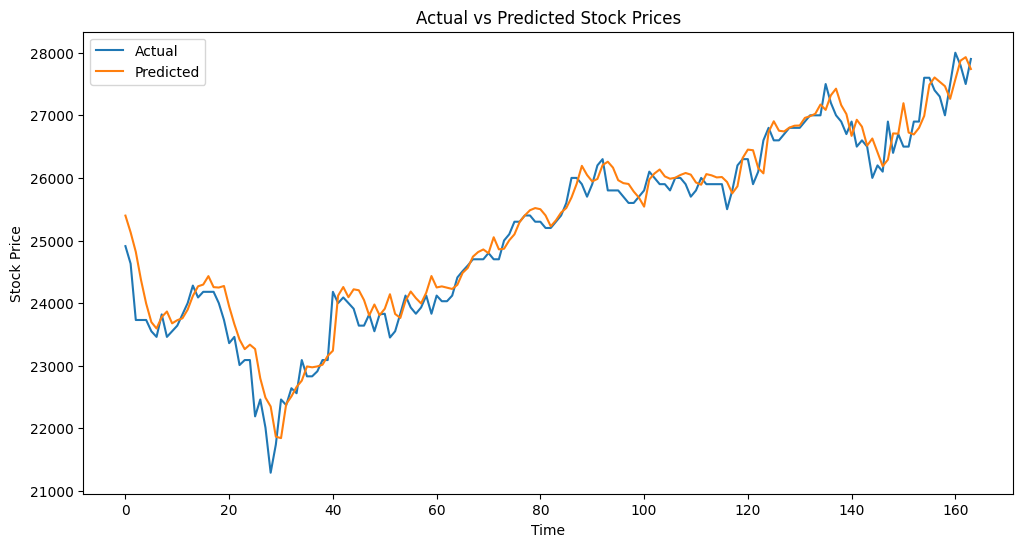

In [458]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    test_output = model(X_test)
    test_loss = criterion(test_output, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

# Inverse transform the predictions and actual values for plotting
test_output_np = test_output.numpy()
y_test_np = y_test.numpy()

test_output_scaled = scaler.inverse_transform(test_output_np)
y_test_scaled = scaler.inverse_transform(y_test_np)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled[:, -1], label='Actual')
plt.plot(test_output_scaled[:, -1], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

# Predict next days

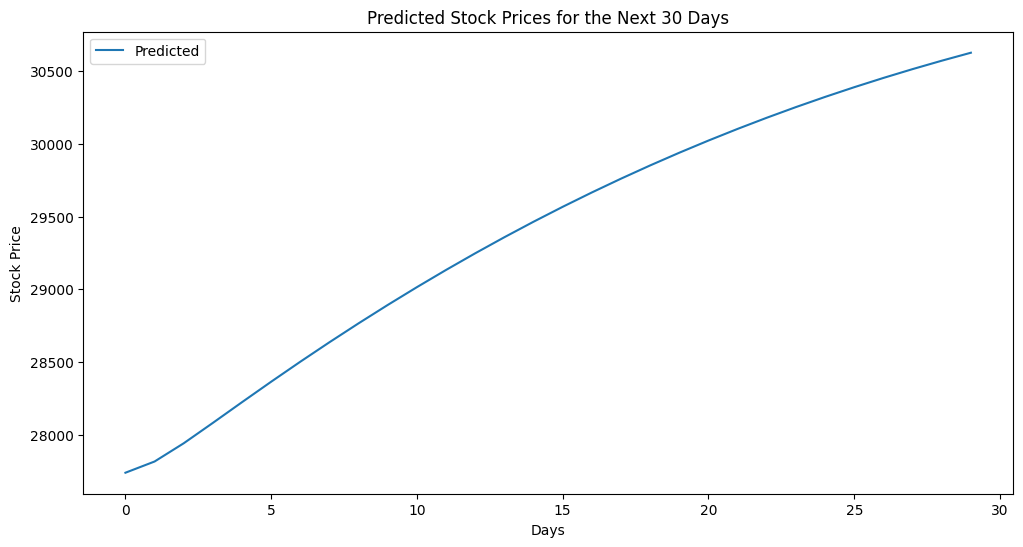

In [459]:
# Predict the next 30 days
num_days = 30

# Last day of the test data
last_day = X_test[-1].unsqueeze(0)  # Reshape to match model input

# Create a copy of the last day to use for predictions
next_day = last_day.clone()

# Store the predicted values
predicted_prices = []

# Predict the next day's price and use it for the next prediction
with torch.no_grad():
    for _ in range(num_days):
        # Predict the next day's price
        prediction = model(next_day)
        
        # Append the prediction to the list of predicted prices
        predicted_prices.append(prediction.squeeze().numpy())
        
        # Update the next_day tensor with the new prediction
        next_day = torch.cat((next_day[:, 1:, :], prediction.unsqueeze(0)), dim=1)

# Convert the list of predicted prices to a numpy array
predicted_prices = np.array(predicted_prices)

# Inverse transform the predicted prices to get them back to the original scale
predicted_prices_scaled = scaler.inverse_transform(predicted_prices)

# Plot the predicted prices for the next 30 days
plt.figure(figsize=(12, 6))
plt.plot(predicted_prices_scaled[:, -1], label='Predicted')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Predicted Stock Prices for the Next 30 Days')
plt.legend()
plt.show()
